In [10]:
%cd ..

/scratch/gpfs/zzada/fconv


In [2]:
from glob import glob

import pickle
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from scipy.io import wavfile
from scipy.stats import zscore

import pandas as pd
# from nilearn import datasets
# from nilearn.maskers import NiftiMasker, NiftiLabelsMasker
from util.path import Path
from util import subject
from constants import RUNS, NRUNS, TR, CONFOUNDS

In [3]:
sub = 5
run = None
trial = None
item = None
first = None
conv = subject.get_conv(sub)

In [4]:
eventpath = Path(
    root="stimuli",
    conv=conv,
    datatype="transcript",
    run=run,
    trial=trial if trial is not None else None,
    item=item,
    condition=None,
    first=first,
    suffix="aligned",
    ext=".csv",
)
eventpath

stimuli/conv-105/transcript/conv-105_aligned.csv

In [5]:
search_str = eventpath.starstr(['conv', 'datatype'])
print(search_str)
files = glob(search_str)
for fn in files:
    print(fn)

stimuli/conv-105/transcript/conv-105*_aligned.csv
stimuli/conv-105/transcript/conv-105_run-3_set-2_trial-12_item-12_condition-G_first-B_aligned.csv
stimuli/conv-105/transcript/conv-105_run-2_set-1_trial-5_item-5_condition-G_first-A_aligned.csv
stimuli/conv-105/transcript/conv-105_run-1_set-1_trial-1_item-1_condition-G_first-B_aligned.csv
stimuli/conv-105/transcript/conv-105_run-4_set-2_trial-14_item-13_condition-G_first-B_aligned.csv
stimuli/conv-105/transcript/conv-105_run-5_set-3_trial-18_item-18_condition-G_first-A_aligned.csv
stimuli/conv-105/transcript/conv-105_run-2_set-1_trial-7_item-7_condition-G_first-A_aligned.csv
stimuli/conv-105/transcript/conv-105_run-3_set-2_trial-10_item-10_condition-G_first-A_aligned.csv
stimuli/conv-105/transcript/conv-105_run-4_set-3_trial-16_item-16_condition-G_first-B_aligned.csv
stimuli/conv-105/transcript/conv-105_run-5_set-3_trial-20_item-19_condition-G_first-B_aligned.csv
stimuli/conv-105/transcript/conv-105_run-1_set-1_trial-4_item-4_condition-

In [6]:
eventpath = Path.frompath(files[0].split('/')[-1])
eventpath.update(root='stimuli', datatype='transcript')
eventpath

stimuli/conv-105/transcript/conv-105_run-3_set-2_trial-12_item-12_condition-G_first-B_aligned.csv

# Visualize transcript

In [53]:
df = pd.read_csv(eventpath)
df.ffill(inplace=True)
df

,speaker,sentence,word,start,end,score
0,4,1,Um...,2.341,2.482,0.746
1,4,1,can,4.108,4.229,0.523
2,4,1,you,4.249,4.369,0.778
3,4,1,summarize,4.390,4.751,0.528
4,4,1,the,4.791,4.871,0.953
...,...,...,...,...,...,...
490,4,2,it,176.524,176.597,0.252
491,4,2,definitely,176.645,177.224,0.413
492,4,2,plays,177.297,177.562,0.735
493,4,2,a,177.659,177.900,0.576


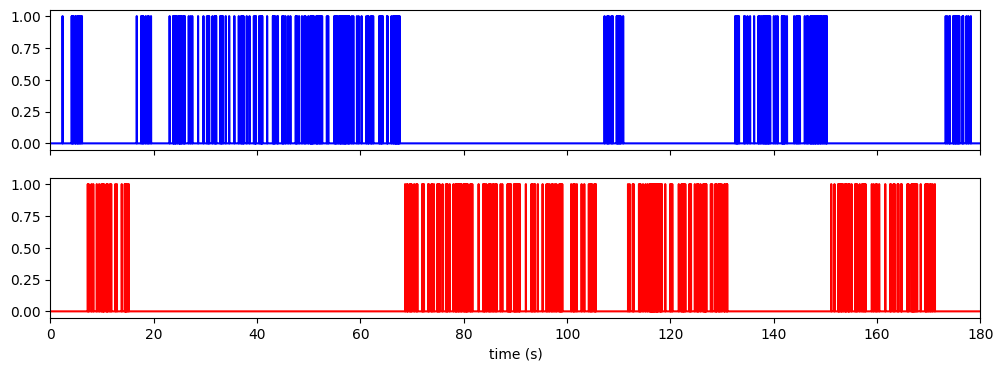

In [56]:
xaxis = np.arange(180 * 1000) / 1000

upto = int(df.start.max() * 1000) + 1
subA = np.zeros(180000)
subA[(df[df.speaker == sub].start * 1000).astype(int)] = 1

subB = np.zeros_like(subA)
subB[(df[df.speaker != sub].start * 1000).astype(int)] = 1

fig, axes = plt.subplots(2, 1, figsize=(12, 4), sharex=True)
axes[0].set_xlim(0, 180)
axes[0].plot(xaxis, subA, color="blue")
axes[1].plot(xaxis, subB, color="red")
axes[1].set_xlabel("time (s)")
fig.show()

# Fig 1

In [7]:
run = eventpath['run']
trial = ((int(eventpath["trial"]) - 1) % 4) + 1
slices = [slice(i, i+240) for i in range(0, 1200, 240)]
run, trial

(3, 4)

In [8]:
from encoding import build_regressors

In [9]:
X, _ = build_regressors(sub, modelname='model-gpt2-medium_layer-0.75')
X.shape

(1200, 2135)

In [10]:
id_vars = X[slices[run-1], [1, 2]][:120]
id_vars.shape

(120, 2)

In [77]:
# dfemb = subject.get_transcript(sub, modelname='model-gpt2-medium_layer-0.75')
# df2 = dfemb[(dfemb.run == run) & (dfemb.trial == eventpath['trial'])]
# df2['word,speaker,sentence,start'.split(',')]

In [11]:
data = subject.get_bold(sub, use_cache=True)
run_data = data[slices[run-1]]
trial_data = run_data[:120] # get first trial always (can fix later)
trial_data.shape

(120, 81924)

In [12]:
dataB = subject.get_bold(subject.get_partner(sub), use_cache=True)
run_dataB = dataB[slices[run-1]]
trial_dataB = run_dataB[:120] # get first trial always (can fix later)
trial_dataB.shape

(120, 81924)

In [13]:
audiopath = eventpath.copy()
audiopath.update(datatype='audio', suffix=None, ext='.wav')
fs, audio_data = wavfile.read(audiopath)
audio_data.shape

(2871296,)

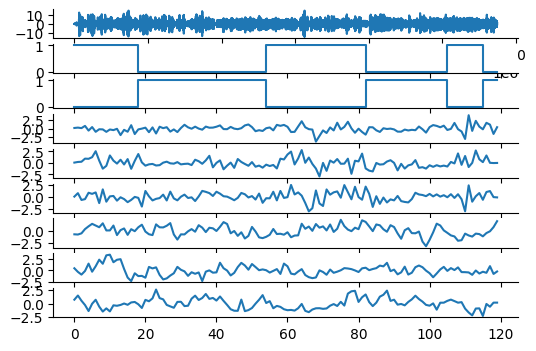

In [14]:
fig, axes = plt.subplots(9, 1, figsize=(6, 4))
axes[0].plot(zscore(audio_data))
axes[1+0].step(np.arange(120), id_vars[:, 0])
axes[1+1].step(np.arange(120), id_vars[:, 1])
axes[1+2].plot(zscore(trial_data[:, 1]))
axes[1+3].plot(zscore(trial_data[:, 0]))
axes[1+4].plot(zscore(trial_data[:, 3]))
axes[1+5].plot(zscore(trial_dataB[:, 1]))
axes[1+6].plot(zscore(trial_dataB[:, 0]))
axes[1+7].plot(zscore(trial_dataB[:, 300]))
for ax in axes:
    sns.despine(ax=ax)
# fig.savefig('figures/fig1-artifacts.svg')
fig.show()

In [15]:
from matplotlib.collections import LineCollection
from matplotlib.colors import BoundaryNorm, ListedColormap

In [22]:
bounds = np.diff(id_vars[:, 0]).nonzero()[0]

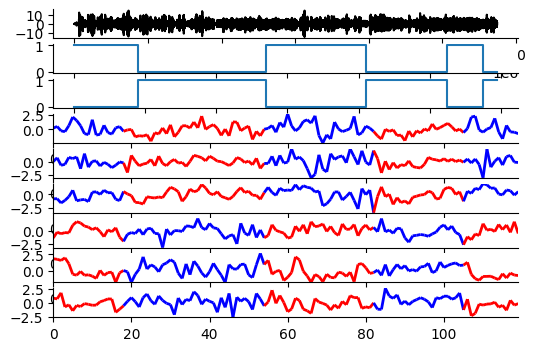

In [59]:
x = np.arange(120)

fig, axes = plt.subplots(9, 1, figsize=(6, 4))
axes[0].plot(zscore(audio_data), c='k')
axes[1+0].step(x, id_vars[:, 0])
axes[1+1].step(x, id_vars[:, 1])

for i in range(2, 5):
    ax = axes[1+i]
    y = zscore(trial_data[:, i])

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    cmap = ListedColormap(['b', 'r', 'b', 'r', 'b'])
    norm = BoundaryNorm([0] + list(bounds), cmap.N)
    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(x)
    lc.set_linewidth(2)
    ax.add_collection(lc)
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(y.min(), y.max())

for i in range(5, 8):
    ax = axes[1+i]
    y = zscore(trial_dataB[:, i])

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    cmap = ListedColormap(['r', 'b', 'r', 'b', 'r',])
    norm = BoundaryNorm([0] + list(bounds), cmap.N)
    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(x)
    lc.set_linewidth(2)
    ax.add_collection(lc)
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(y.min(), y.max())

for ax in axes:
    sns.despine(ax=ax)
fig.savefig('figures/fig1-artifacts.svg')
fig.show()

# brain plot

In [12]:
from neuromaps.datasets import fetch_fslr
from surfplot import Plot

surfaces = fetch_fslr()
lh, rh = surfaces['inflated']
p = Plot(lh, rh)

 ...done. (2 seconds, 0 min)
Extracting data from /home/zzada/neuromaps-data/599046a594e0e45c04e90291c2348cbe/fsLR32k.tar.gz..... done.


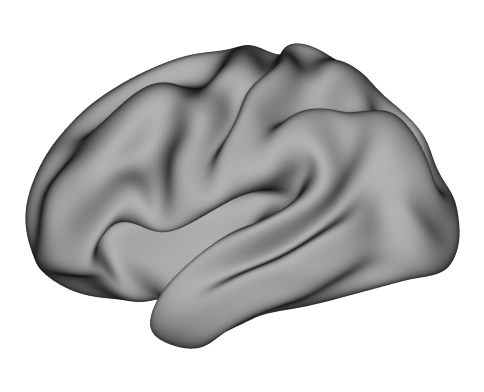

In [14]:
p = Plot(lh, views='lateral')
fig = p.build()
fig.savefig('figures/fig1-brains.svg')